In [1]:
from base64image import Base64Image
import onnxruntime
import numpy as np
from PIL import Image
import os, random
import boto3
import cv2
from skimage import io, transform, color
import requests, json, time
from io import BytesIO
import base64, hashlib

In [2]:
def tensor2img(tensor, out_type=np.uint8, min_max=(0, 1)):
    tensor = np.transpose(tensor, (1, 2, 0))
    tensor = np.clip(tensor, *min_max)
    tensor = (tensor - min_max[0]) / (min_max[1] - min_max[0])
    img_np = (tensor * 255.0).round()
    return img_np.astype(out_type)

In [3]:
def download():
    file_list = [('https://xiaotih.s3.us-west-2.amazonaws.com/AIKits/Real_ESRGAN_x2.onnx', '6505c715787eac6060ff2ce9cd1c022ec1230f16'),
                 ('https://xiaotih.s3.us-west-2.amazonaws.com/AIKits/Real_ESRGAN_x4.onnx', '245e79a4ce95cfce6d55a98ad5161518a8a18631')]
    for url, sha1_hash in file_list:
        fname = os.path.join('/tmp', url.split('/')[-1])
        if os.path.exists(fname):
            sha1 = hashlib.sha1()
            with open(fname, 'rb') as f:
                while True:
                    data = f.read(1048576)
                    if not data:
                        break
                    sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                continue  # Hit cache
        r = requests.get(url, stream=True, verify=True)
        
        with open(fname, 'wb') as f:
            f.write(r.content)
 
download()

KeyboardInterrupt: 

In [4]:
ort_session_x2 = onnxruntime.InferenceSession('/Users/yiyanz/Solutions/2021-03_AI_portal/Projects/Aws-gcr-ai-solution-kit/ai-kits/src/Aws-gcr-ai-solution-kit/source/super-resolution/model/Real_ESRGAN_x2.onnx')
ort_session_x4 = onnxruntime.InferenceSession('/Users/yiyanz/Solutions/2021-03_AI_portal/Projects/Aws-gcr-ai-solution-kit/ai-kits/src/Aws-gcr-ai-solution-kit/source/super-resolution/model/Real_ESRGAN_x4.onnx')

In [5]:
def lambda_handler(event):
    if 'body' not in event:
        return {
            'statusCode': 200,
            'headers': {
                'Access-Control-Allow-Headers': '*',
                'Access-Control-Allow-Origin': '*',
                'Access-Control-Allow-Methods': '*'
            }
        }
    if isinstance(event['body'], str):
        body = json.loads(event['body'])
    else:
        body = event['body']
    if 'url' in body:
        uri = body['url']
        base64_image = Base64Image.from_uri(uri)
    else:
        base64_image = Base64Image.from_base64_image_string(body['img'])
    scale = int(body.get('scale', 2))
    if scale == 4:
        ort_session = ort_session_x4
    else:
        ort_session = ort_session_x2
    pil_image = base64_image.get_pil_image()
    src = np.asarray(pil_image)[:,:,:3]
    in_frame = (np.ascontiguousarray(np.transpose(src, (2, 0, 1)))/255).astype('float32')
    ort_inputs = {ort_session.get_inputs()[0].name: np.expand_dims(in_frame, 0)}
    ort_outs = ort_session.run(None, ort_inputs)
    rlt = tensor2img(ort_outs[0][0])
    imo = Image.fromarray(rlt)
    buffered = BytesIO()
    imo.save(buffered, format="png")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    
    result = {'result': img_str}
    return {
        'statusCode': 200,
        'headers': {
            'Content-Type': 'application/json',
            'Access-Control-Allow-Headers': 'Content-Type',
            'Access-Control-Allow-Origin': '*',
            'Access-Control-Allow-Methods': 'POST,GET'
        },
        
        'body': json.dumps(result)
    }

In [9]:
event = {
  "body": {
      "url": "https://xiaotih.s3.us-west-2.amazonaws.com/AIKits/dog.png",
      "scale": "2"
  }
}

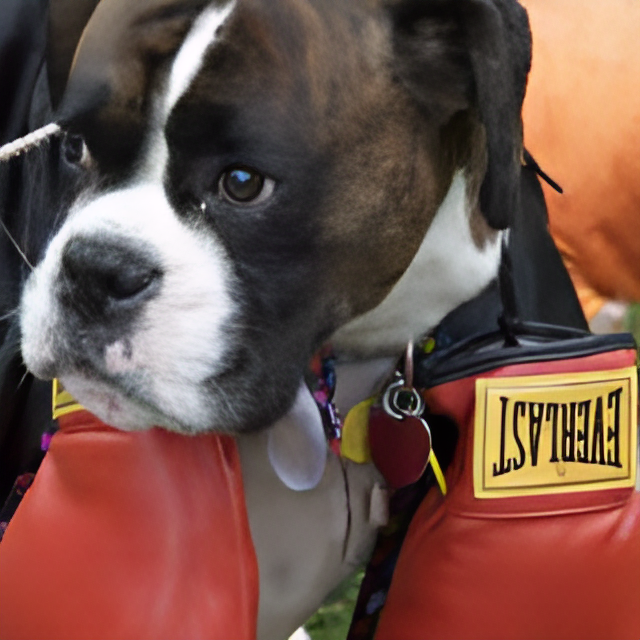

In [11]:
ResultMask = json.loads(lambda_handler(event)['body'])['result']
rlt = Base64Image.from_base64_image_string(ResultMask).get_pil_image()
Base64Image.from_base64_image_string(ResultMask).get_pil_image()

In [8]:
rlt.size

(640, 640)